In [ ]:
# Credit Risk Modeling

In [62]:
# Import Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load Processed Data
X_train = pd.read_csv('../data/processed/X_train.csv')
X_test = pd.read_csv('../data/processed/X_test.csv')

# Load target variables properly - ensure 1D arrays
y_train_df = pd.read_csv('../data/processed/y_train.csv')
y_test_df = pd.read_csv('../data/processed/y_test.csv', index_col=0)

# Extract the loan_status column and convert to 1D numpy array
y_train = y_train_df['loan_status'].values
y_test = y_test_df['loan_status'].values

# Convert boolean columns to int after loading
bool_cols = X_train.select_dtypes(include=['bool']).columns
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")
print(f"y_train type: {type(y_train)}, y_test type: {type(y_test)}")
print(f"Boolean columns converted: {list(bool_cols)}")
print(f"Unique y_train values: {np.unique(y_train)}")
print(f"Unique y_test values: {np.unique(y_test)}")
print(f"X_test and y_test shapes match: {X_test.shape[0] == y_test.shape[0]}")
print(f"y_train is 1D: {len(y_train.shape) == 1}")
print(f"y_test is 1D: {len(y_test.shape) == 1}")

Train shape: (19624, 29), Test shape: (4906, 29)
y_train shape: (19624,), y_test shape: (4906,)
y_train type: <class 'numpy.ndarray'>, y_test type: <class 'numpy.ndarray'>
Boolean columns converted: ['person_home_ownership_OTHER', 'person_home_ownership_OWN', 'person_home_ownership_RENT', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'age_group_26-35', 'age_group_36-45', 'age_group_46-55', 'age_group_56+', 'income_group_Lower-Middle', 'income_group_Middle', 'income_group_Upper-Middle', 'income_group_High']
Unique y_train values: [0 1]
Unique y_test values: [0 1]
X_test and y_test shapes match: True


## Handle Class Imbalance

In [64]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(zip(np.unique(y_train), class_weights))
print("Class weights:", class_weight_dict)

# Check class distribution
print("\nClass Distribution:")
print(f"Training - Class 0: {np.sum(y_train == 0)} ({np.mean(y_train == 0):.1%})")
print(f"Training - Class 1: {np.sum(y_train == 1)} ({np.mean(y_train == 1):.1%})")
print(f"Test - Class 0: {np.sum(y_test == 0)} ({np.mean(y_test == 0):.1%})")
print(f"Test - Class 1: {np.sum(y_test == 1)} ({np.mean(y_test == 1):.1%})")

Class weights: {np.int64(0): np.float64(0.6486843845035039), np.int64(1): np.float64(2.1814139617607826)}

Class Distribution:
Training - Class 0: 15126 (77.1%)
Training - Class 1: 4498 (22.9%)
Test - Class 0: 3781 (77.1%)
Test - Class 1: 1125 (22.9%)


In [65]:
# Logistic Regression Baseline
baseline_model = LogisticRegression(random_state=42, class_weight=class_weight_dict, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test)
y_pred_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]

print("=== Baseline Model - Logistic Regression ===")
print(classification_report(y_test, y_pred_baseline))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_baseline):.4f}")

=== Baseline Model - Logistic Regression ===
              precision    recall  f1-score   support

           0       0.93      0.80      0.86      3781
           1       0.55      0.80      0.65      1125

    accuracy                           0.80      4906
   macro avg       0.74      0.80      0.76      4906
weighted avg       0.84      0.80      0.81      4906

ROC AUC: 0.8788


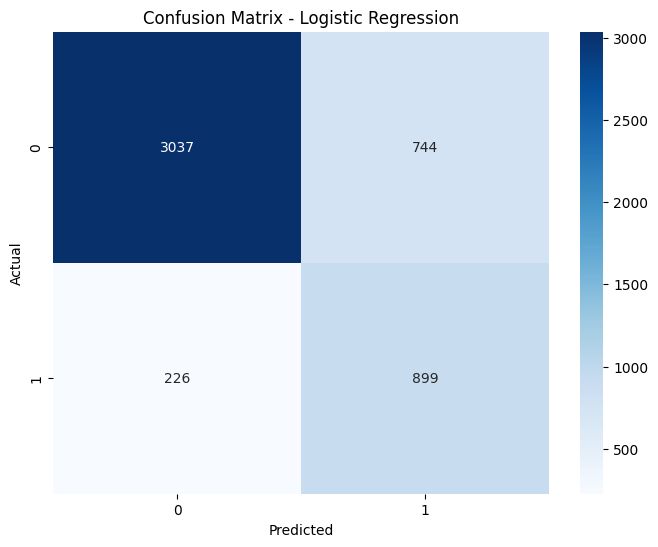

In [ ]:
# Logistic Regression Baseline
baseline_model = LogisticRegression(random_state=42, class_weight=class_weight_dict, max_iter=1000)
baseline_model.fit(X_train, y_train)

# Predictions
y_pred_baseline = baseline_model.predict(X_test)
y_pred_proba_baseline = baseline_model.predict_proba(X_test)[:, 1]  # Get probability for class 1

print("=== Baseline Model - Logistic Regression ===")
print(classification_report(y_test, y_pred_baseline))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_baseline):.4f}")

In [67]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("=== Random Forest Model ===")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

=== Random Forest Model ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3781
           1       0.95      0.75      0.84      1125

    accuracy                           0.93      4906
   macro avg       0.94      0.87      0.90      4906
weighted avg       0.93      0.93      0.93      4906

ROC AUC: 0.9430


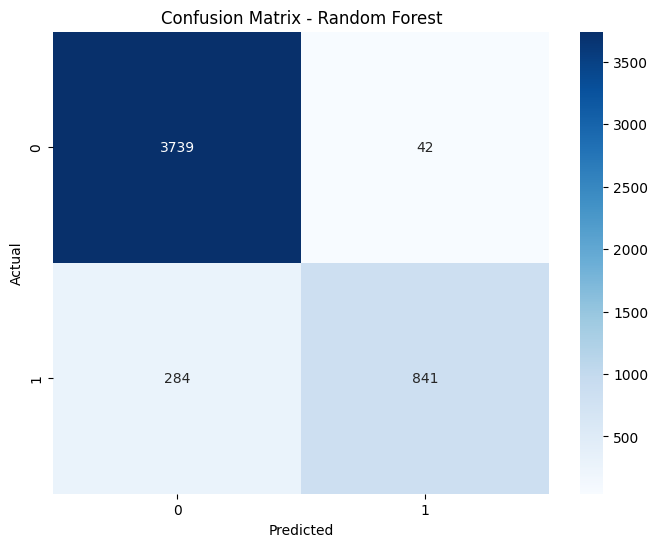

In [ ]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42, class_weight=class_weight_dict)
rf_model.fit(X_train, y_train)

# Predictions
y_pred_rf = rf_model.predict(X_test)
y_pred_proba_rf = rf_model.predict_proba(X_test)[:, 1]  # Get probability for class 1

print("=== Random Forest Model ===")
print(classification_report(y_test, y_pred_rf))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_rf):.4f}")

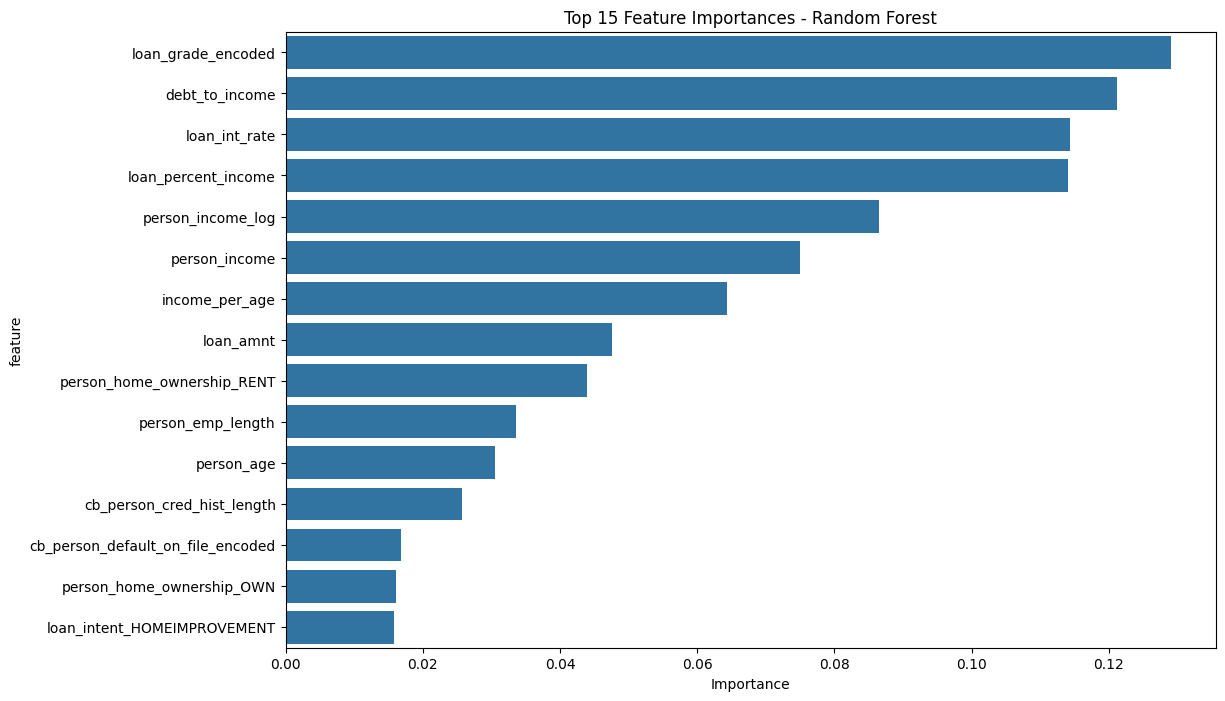

In [68]:
# Feature Importance for Random Forest
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance.head(15), x='importance', y='feature')
plt.title('Top 15 Feature Importances - Random Forest')
plt.xlabel('Importance')
plt.show()

## Hyperparameter Tuning

In [69]:
# Grid Search for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, class_weight=class_weight_dict), 
    param_grid, 
    cv=3, 
    scoring='roc_auc', 
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation ROC AUC:", grid_search.best_score_)

best_rf_model = grid_search.best_estimator_

Best parameters: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation ROC AUC: 0.935281903436528


## Best Model Evaluation

In [71]:
# Evaluate Best Model
y_pred_best = best_rf_model.predict(X_test)
y_pred_proba_best = best_rf_model.predict_proba(X_test)[:, 1]

print("=== Best Random Forest Model ===")
print(classification_report(y_test, y_pred_best))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")

=== Best Random Forest Model ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96      3781
           1       0.96      0.76      0.85      1125

    accuracy                           0.94      4906
   macro avg       0.94      0.87      0.90      4906
weighted avg       0.94      0.94      0.93      4906

ROC AUC: 0.9452


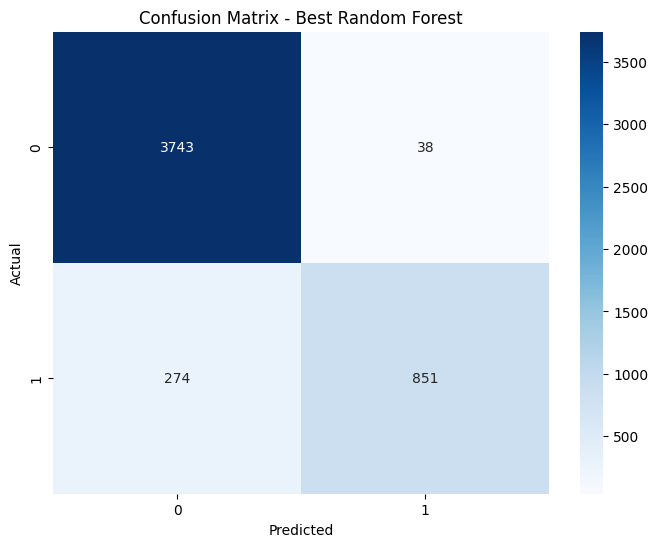

In [ ]:
# Evaluate Best Model
y_pred_best = best_rf_model.predict(X_test)
y_pred_proba_best = best_rf_model.predict_proba(X_test)[:, 1]  # Get probability for class 1

print("=== Best Random Forest Model ===")
print(classification_report(y_test, y_pred_best))
print(f"ROC AUC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")

## Model Comparison

In [73]:
# Compare all models
models_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'Best Random Forest'],
    'ROC AUC': [
        roc_auc_score(y_test, y_pred_proba_baseline),
        roc_auc_score(y_test, y_pred_proba_rf),
        roc_auc_score(y_test, y_pred_proba_best)
    ],
    'Accuracy': [
        np.mean(y_pred_baseline == y_test),
        np.mean(y_pred_rf == y_test),
        np.mean(y_pred_best == y_test)
    ],
    'Precision (Default)': [
        classification_report(y_test, y_pred_baseline, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['precision'],
        classification_report(y_test, y_pred_best, output_dict=True)['1']['precision']
    ],
    'Recall (Default)': [
        classification_report(y_test, y_pred_baseline, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_rf, output_dict=True)['1']['recall'],
        classification_report(y_test, y_pred_best, output_dict=True)['1']['recall']
    ]
})

print("=== Model Comparison ===")
print(models_comparison.round(4))

=== Model Comparison ===
                 Model  ROC AUC  Accuracy  Precision (Default)  \
0  Logistic Regression   0.8788    0.8023               0.5472   
1        Random Forest   0.9430    0.9336               0.9524   
2   Best Random Forest   0.9452    0.9364               0.9573   

   Recall (Default)  
0            0.7991  
1            0.7476  
2            0.7564  


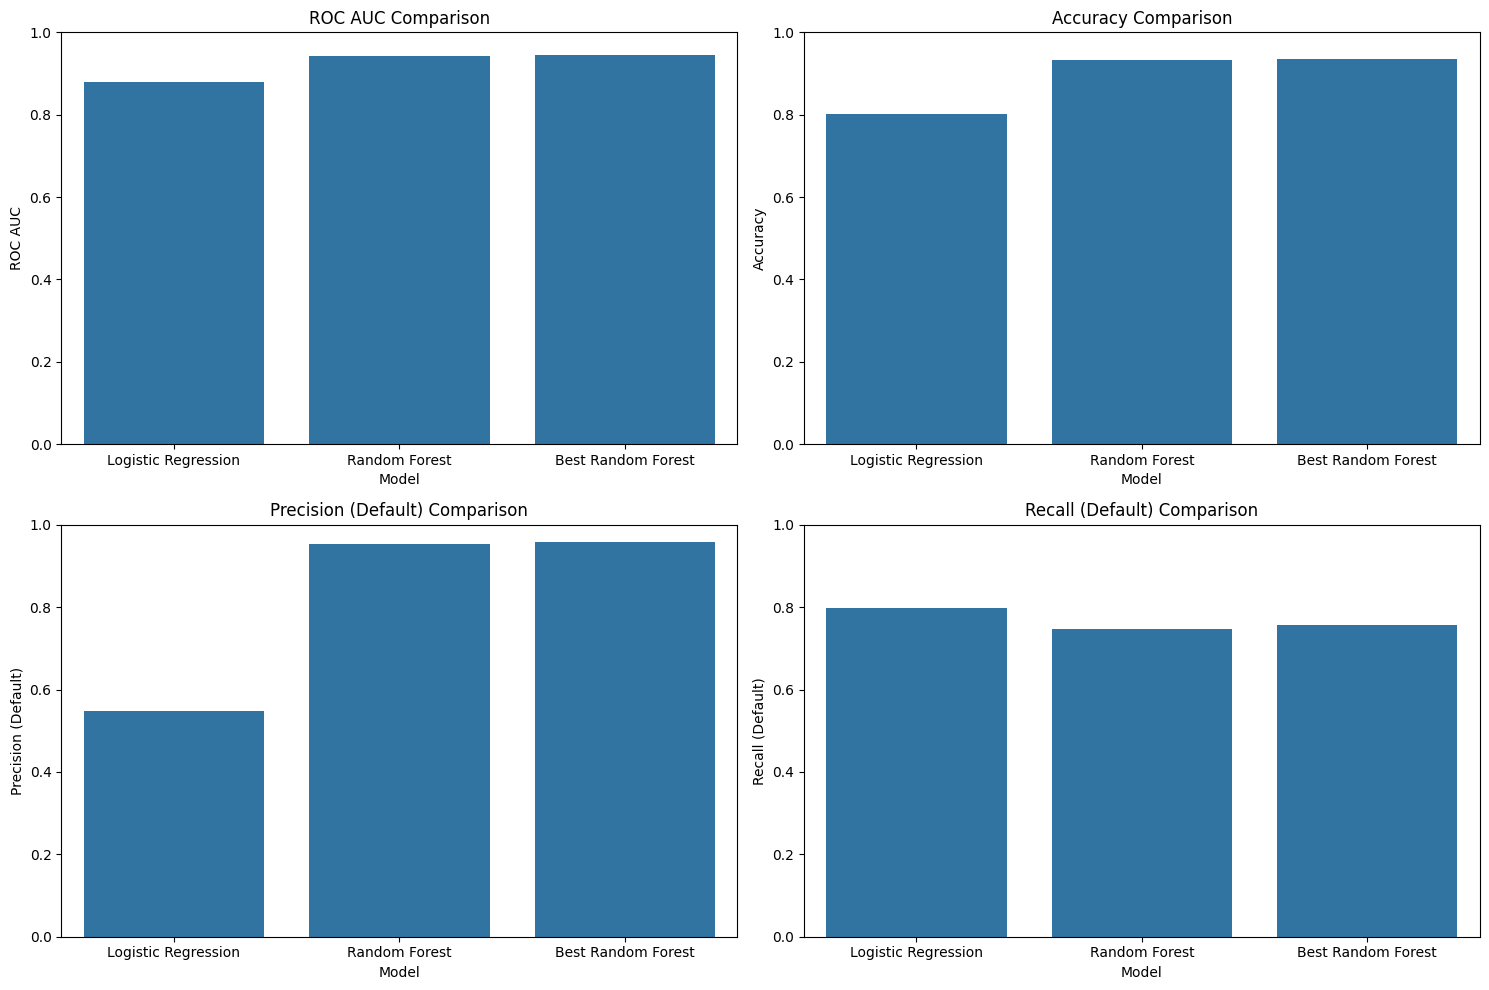

In [74]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ROC AUC
sns.barplot(data=models_comparison, x='Model', y='ROC AUC', ax=axes[0,0])
axes[0,0].set_title('ROC AUC Comparison')
axes[0,0].set_ylim(0, 1)

# Accuracy
sns.barplot(data=models_comparison, x='Model', y='Accuracy', ax=axes[0,1])
axes[0,1].set_title('Accuracy Comparison')
axes[0,1].set_ylim(0, 1)

# Precision
sns.barplot(data=models_comparison, x='Model', y='Precision (Default)', ax=axes[1,0])
axes[1,0].set_title('Precision (Default) Comparison')
axes[1,0].set_ylim(0, 1)

# Recall
sns.barplot(data=models_comparison, x='Model', y='Recall (Default)', ax=axes[1,1])
axes[1,1].set_title('Recall (Default) Comparison')
axes[1,1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Save Best Model

In [78]:
# Save the best model
os.makedirs('../models', exist_ok=True)
joblib.dump(best_rf_model, '../models/best_model.pkl')

# Save model comparison
models_comparison.to_csv('../models/model_comparison.csv', index=False)

print("=== Model Saved Successfully ===")
print(f"✓ Best model saved: ../models/best_model.pkl")
print(f"✓ Model comparison saved: ../models/model_comparison.csv")
print(f"✓ Best ROC AUC: {roc_auc_score(y_test, y_pred_proba_best):.4f}")
print(f"✓ Best Accuracy: {np.mean(y_pred_best == y_test):.4f}")

=== Model Saved Successfully ===
✓ Best model saved: ../models/best_model.pkl
✓ Model comparison saved: ../models/model_comparison.csv
✓ Best ROC AUC: 0.9452
✓ Best Accuracy: 0.9364
